# Tuning Confidence Score of Flight Call Detections
_Ashley Huang, Carlene English_, _Benjamin Van Doren_

In [1578]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import gaussian_kde
from scipy.special import logit
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import suncalc
import os
for path in ['exports', 'exports/csv', 'exports/figures']:
    if not os.path.exists(path):
        os.makedirs(path)

In [1579]:
taxon = 'greyel'

common_names = {
    'greyel': 'Greater Yellowlegs', 
    'semplo': 'Semipalmated Plover', 
    'lobcur': 'Long-billed Curlew', 
    'uplsan': 'Upland Sandpiper', 
    'baisan': 'Baird\'s Sandpiper', 
    'wilsni': 'Wilson\'s Snipe', 
    'leasan': 'Least Sandpiper'
}

## 1. Plot the distribution of confidence scores
The `reviewStutus` column of the exported CSV file can be either `Reviewed`, `Problem`, or `Unreviewed`. In this notebook, we will use _correct_ and _incorrect_ to describe `Reviewed` and `Problem` detections; the term _reviewed_ will denote both _correct_ and _incorrect_ detections.
We plot histograms of the confidence scores of `Reviewed`, 

reviewStatus
Unreviewed    4551
Reviewed       484
Problem        391
Name: count, dtype: int64

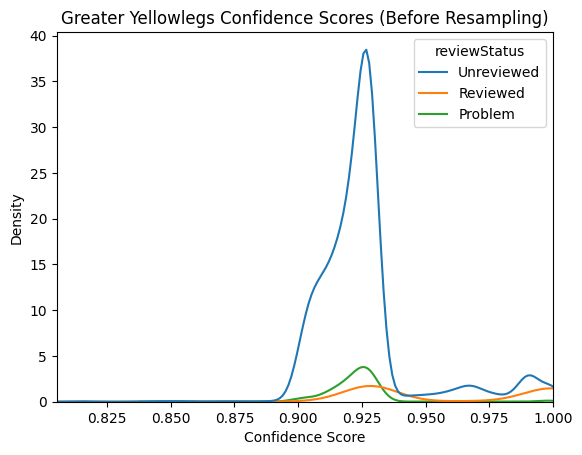

In [1580]:
if taxon == 'uplsan':
    df_flood = pd.read_csv(f'detections/uplsan_flood.csv')
    df_correct = pd.read_csv(f'detections/uplsan_correct.csv')
    df_incorrect = pd.read_csv(f'detections/uplsan_incorrect.csv')
    df = pd.concat([df_flood, df_correct, df_incorrect])
else:
    df = pd.read_csv(f'detections/{taxon}.csv')

sns.kdeplot(df, x='confidenceScore', hue='reviewStatus')
plt.title(f'{common_names[taxon]} Confidence Scores (Before Resampling)')
plt.xlabel('Confidence Score')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.savefig(f'exports/figures/br_{taxon}.png')

df['reviewStatus'].value_counts()

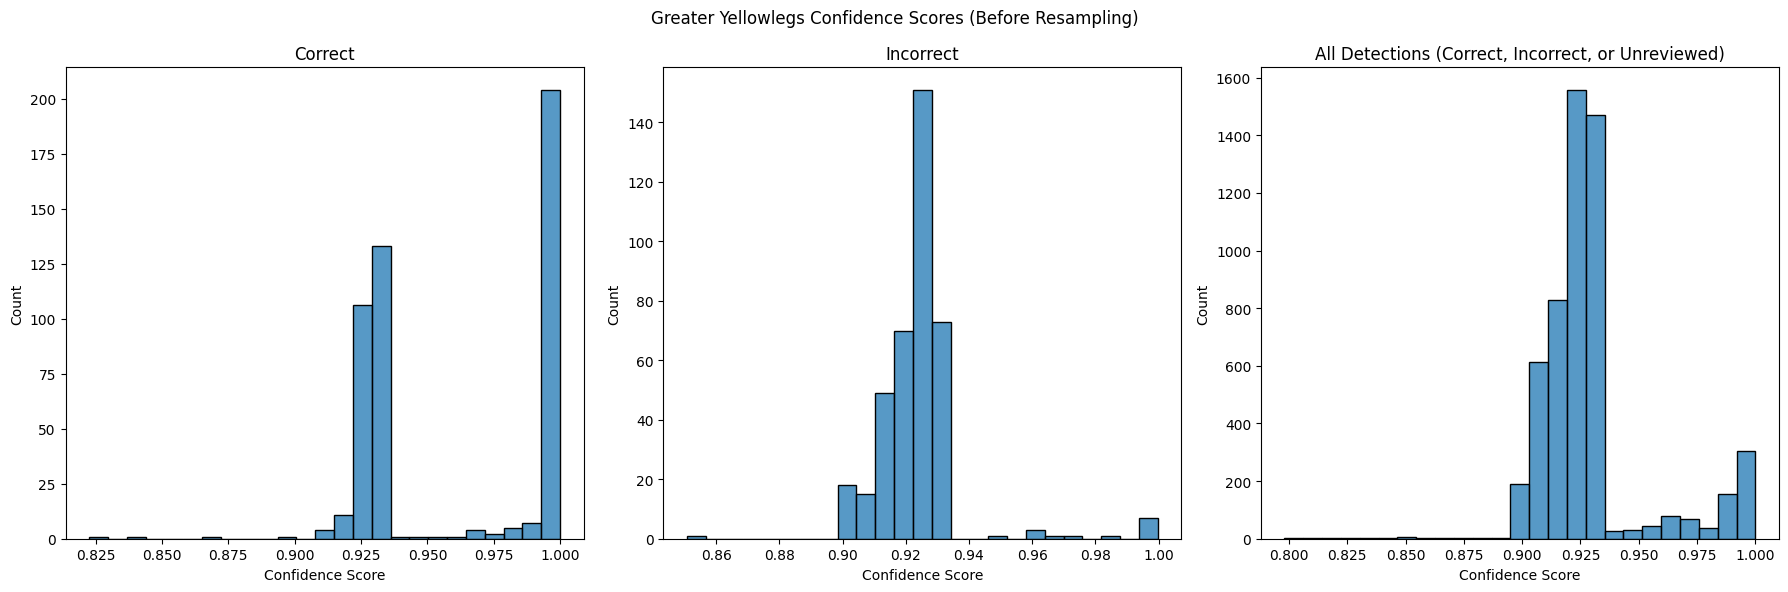

In [1581]:
# Plot a historgram for each review status
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(df[df['reviewStatus'] == 'Reviewed']['confidenceScore'].values, bins=25, ax=axes[0])
sns.histplot(df[df['reviewStatus'] == 'Problem']['confidenceScore'].values, bins=25, ax=axes[1])
sns.histplot(df['confidenceScore'].values, bins=25, ax=axes[2])
axes[0].set_title('Correct')
axes[1].set_title('Incorrect')
axes[2].set_title('All Detections (Correct, Incorrect, or Unreviewed)')
axes[0].set_xlabel('Confidence Score')
axes[1].set_xlabel('Confidence Score')
axes[2].set_xlabel('Confidence Score')
plt.suptitle(f'{common_names[taxon]} Confidence Scores (Before Resampling)')
plt.tight_layout()

## 2. Filter Out Daytime Detections
First, we filter out unreviewed detections and assign 0/1 to incorrect/correct detections. Then, we filter out daytime flight calls. Timestamps are compared to the sunset/sunrise time of MPG ranch. Once we obtained coordinated of each site, timestamp should be compared to the sunset/sunrise time of the corresponding site.

In [1582]:
# Filter out unreviewed detections
df['reviewStatusBinary'] = df['reviewStatus'].map({'Reviewed': 1, 'Problem': 0, 'Unreviewed': -1})
df_reviewed = df[df['reviewStatusBinary'] >= 0]

# Filter by sunset and sunrise time
def get_sameday_dawn_dusk(utc_time, lon, lat):
    # Turns out Suncalc doesn't return the times of the same day. 
    # Instead, if the time has passed sunset, Suncalc returns the times of the next day.
    next_sunset = suncalc.get_times(utc_time, lon, lat)
    prev_sunset = suncalc.get_times(utc_time - timedelta(days=1), lon, lat)
    if (next_sunset['nautical_dawn'] - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date():
        utc_dawn, utc_dusk = next_sunset['nautical_dawn'], next_sunset['nautical_dusk']
    else:
        utc_dawn, utc_dusk = prev_sunset['nautical_dawn'], prev_sunset['nautical_dusk']
    assert((utc_dawn - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date())
    assert((utc_dusk - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date())
    return utc_dawn, utc_dusk

def is_nocturnal(time_str, dawn_offset=timedelta(minutes=0), dusk_offset=timedelta(minutes=0)):
    utc_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    utc_dawn, utc_dusk = get_sameday_dawn_dusk(utc_time, -116.3273099, 47.0559593)
    if utc_dawn + dawn_offset < utc_time < utc_dusk + dusk_offset:
        return False
    else:
        return True

total_detections = len(df_reviewed.index)
df_reviewed = df_reviewed[df_reviewed['timestamp'].apply(is_nocturnal)]
print('nocturnal detections:', len(df_reviewed.index))
print('durinal detections:', total_detections - len(df_reviewed.index))

nocturnal detections: 274
durinal detections: 601


## 3. Resample Reviewed Detections to Match the Distribution of All Detections

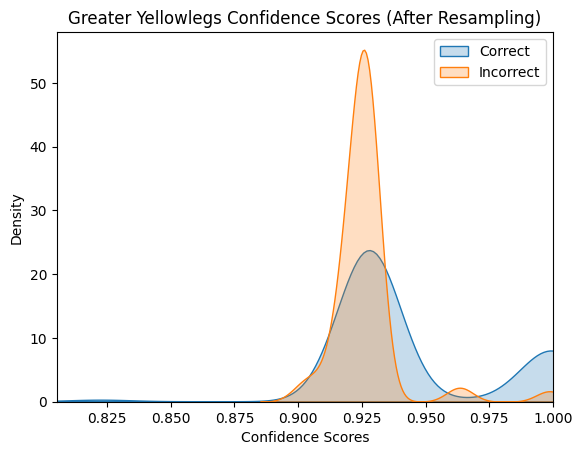

In [1583]:
scores = df['confidenceScore']
scores_reviewed = df_reviewed['confidenceScore']
kde = gaussian_kde(scores)
kde_reviewed = gaussian_kde(scores_reviewed)
weights = kde.evaluate(scores_reviewed) / kde_reviewed.evaluate(scores_reviewed)
weights /= weights.sum()
indicies = np.random.choice(df_reviewed.index, size=len(df_reviewed), p=weights, replace=True)
df_resampled = df_reviewed.loc[indicies]
df_resampled.to_csv(f'exports/csv/{taxon}_resampled.csv', index=False) # save dataframe to exports/csv/

sns.kdeplot(data=df_resampled[df_resampled['reviewStatusBinary'] == 1], x='confidenceScore', label='Correct', fill=True)
sns.kdeplot(data=df_resampled[df_resampled['reviewStatusBinary'] == 0], x='confidenceScore', label='Incorrect', fill=True)
plt.title(f'{common_names[taxon]} Confidence Scores (After Resampling)')
plt.xlabel('Confidence Scores')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.legend()
plt.savefig(f'exports/figures/ar_{taxon}.png')

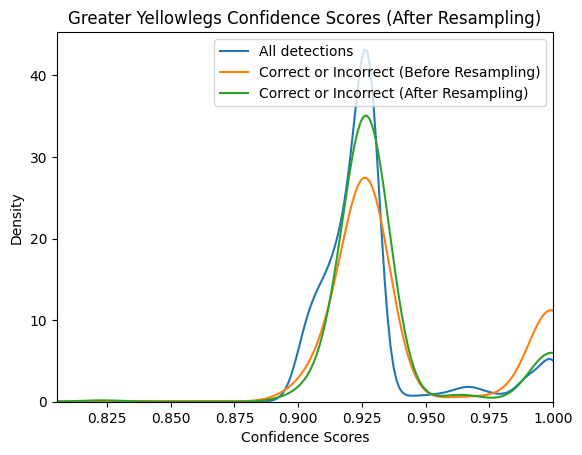

In [1584]:
# Plot the distribution before and after resampling
sns.kdeplot(df['confidenceScore'], color='#1f77b4', label='All detections')
sns.kdeplot(df[df['reviewStatus'].isin(['Reviewed', 'Problem'])]['confidenceScore'].values, color='#ff7f0e', label='Correct or Incorrect (Before Resampling)')
sns.kdeplot(df_resampled['confidenceScore'], color='#2ca02c', label='Correct or Incorrect (After Resampling)')
plt.title(f'{common_names[taxon]} Confidence Scores (After Resampling)')
plt.xlabel('Confidence Scores')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.legend()

## 5. Fit with Logistic Regression

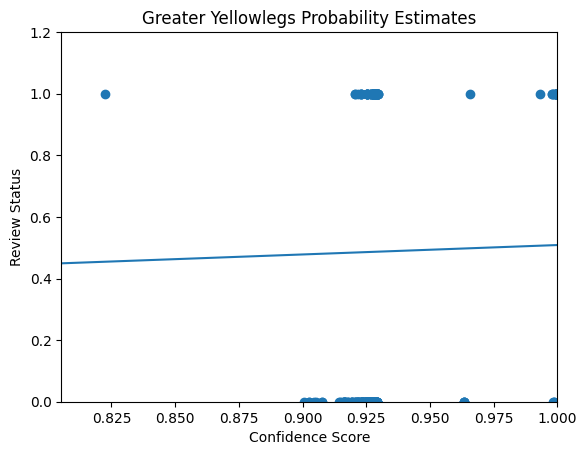

In [1585]:
X = df_resampled['confidenceScore'].values.reshape(-1, 1) # X.shape = (N, 1)
y = df_resampled['reviewStatusBinary'].values # y.shape = (N)

logr = LogisticRegression()
logr.fit(X, y)

plt.scatter(df_resampled['confidenceScore'], df_resampled['reviewStatusBinary'])

# Plot learned probability estimates
x = np.linspace(0, 1, 100).reshape(-1, 1)
y_hat = logr.predict_proba(x)[:, 1]
plt.plot(x, y_hat)
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.ylim(0, 1.2)
plt.xlabel('Confidence Score')
plt.ylabel('Review Status')
plt.title(f'{common_names[taxon]} Probability Estimates')
plt.savefig(f'exports/figures/pe_{taxon}.png')

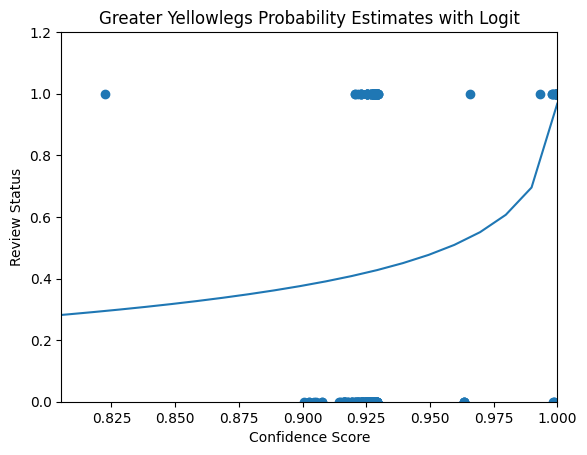

In [ ]:
X = df_resampled['confidenceScore'].values.reshape(-1, 1)
y = df_resampled['reviewStatusBinary'].values
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit

logr = LogisticRegression()
logr.fit(X_logit, y)

plt.scatter(df_resampled['confidenceScore'], df_resampled['reviewStatusBinary'])

# Plot learned probability estimates
x = np.linspace(0, 1, 100).reshape(-1, 1)
x_logit = logit(x.clip(1e-4, 1 - 1e-4)) # apply logit
y_hat = logr.predict_proba(x_logit)[:, 1]
plt.plot(x, y_hat)
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.ylim(0, 1.2)
plt.xlabel('Confidence Score')
plt.ylabel('Review Status')
plt.title(f'{common_names[taxon]} Probability Estimates with Logit')
plt.savefig(f'exports/figures/pel_{taxon}.png')